In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

from sklearn.preprocessing import LabelEncoder, OneHotEncoder

from sklearn.pipeline import Pipeline

# Load datasets

In [2]:
train_X = pd.read_csv('train.csv')
train_y = pd.read_csv('train_label.csv')
test_X = pd.read_csv('test.csv')
test_y = pd.read_csv('test_label.csv')

In [3]:
df = train_X.copy()
df.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed
0,5/2/2012 19:00,Summer,0,1,Clear + Few clouds,22.14,25.760,77,16.9979
1,9/5/2012 4:00,Fall,0,1,Clear + Few clouds,28.70,33.335,79,19.0012
2,1/13/2011 9:00,Spring,0,1,Clear + Few clouds,5.74,6.060,50,22.0028
3,11/18/2011 16:00,Winter,0,1,Clear + Few clouds,13.94,16.665,29,8.9981
4,9/13/2011 13:00,Fall,0,1,Clear + Few clouds,30.34,33.335,51,19.0012


# Join train_label and train_X for data analysis

In [4]:
df['target'] = train_y
df.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,target
0,5/2/2012 19:00,Summer,0,1,Clear + Few clouds,22.14,25.760,77,16.9979,504
1,9/5/2012 4:00,Fall,0,1,Clear + Few clouds,28.70,33.335,79,19.0012,5
2,1/13/2011 9:00,Spring,0,1,Clear + Few clouds,5.74,6.060,50,22.0028,139
3,11/18/2011 16:00,Winter,0,1,Clear + Few clouds,13.94,16.665,29,8.9981,209
4,9/13/2011 13:00,Fall,0,1,Clear + Few clouds,30.34,33.335,51,19.0012,184


# Check for missing values

In [5]:
df.isna().sum()

datetime      0
season        0
holiday       0
workingday    0
weather       0
temp          0
atemp         0
humidity      0
windspeed     0
target        0
dtype: int64

In [6]:
df.isnull().sum()

datetime      0
season        0
holiday       0
workingday    0
weather       0
temp          0
atemp         0
humidity      0
windspeed     0
target        0
dtype: int64

# Finding Correlation between variables

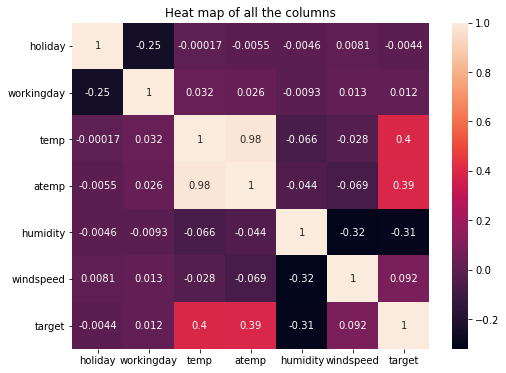

In [7]:
plt.figure(figsize=(8,6))
sns.heatmap(df.corr(), annot=True)
plt.title('Heat map of all the columns')
plt.show()

# Extracting additional features

In [8]:
df.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,target
0,5/2/2012 19:00,Summer,0,1,Clear + Few clouds,22.14,25.760,77,16.9979,504
1,9/5/2012 4:00,Fall,0,1,Clear + Few clouds,28.70,33.335,79,19.0012,5
2,1/13/2011 9:00,Spring,0,1,Clear + Few clouds,5.74,6.060,50,22.0028,139
3,11/18/2011 16:00,Winter,0,1,Clear + Few clouds,13.94,16.665,29,8.9981,209
4,9/13/2011 13:00,Fall,0,1,Clear + Few clouds,30.34,33.335,51,19.0012,184


# Converting datetime to datetime

In [9]:
df['datetime'] = pd.to_datetime(df.datetime)
df.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,target
0,2012-05-02 19:00:00,Summer,0,1,Clear + Few clouds,22.14,25.760,77,16.9979,504
1,2012-09-05 04:00:00,Fall,0,1,Clear + Few clouds,28.70,33.335,79,19.0012,5
2,2011-01-13 09:00:00,Spring,0,1,Clear + Few clouds,5.74,6.060,50,22.0028,139
3,2011-11-18 16:00:00,Winter,0,1,Clear + Few clouds,13.94,16.665,29,8.9981,209
4,2011-09-13 13:00:00,Fall,0,1,Clear + Few clouds,30.34,33.335,51,19.0012,184


# Extracing datetime to year, month, date, hr, min sec

In [10]:
df['year'] = df.datetime.dt.year
df['month'] = df.datetime.dt.month 
df['day'] = df.datetime.dt.day
df['hour'] = df.datetime.dt.hour 
df['minute'] = df.datetime.dt.minute
df['second'] = df.datetime.dt.second
df.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,target,year,month,day,hour,minute,second
0,2012-05-02 19:00:00,Summer,0,1,Clear + Few clouds,22.14,25.760,77,16.9979,504,2012,5,2,19,0,0
1,2012-09-05 04:00:00,Fall,0,1,Clear + Few clouds,28.70,33.335,79,19.0012,5,2012,9,5,4,0,0
2,2011-01-13 09:00:00,Spring,0,1,Clear + Few clouds,5.74,6.060,50,22.0028,139,2011,1,13,9,0,0
3,2011-11-18 16:00:00,Winter,0,1,Clear + Few clouds,13.94,16.665,29,8.9981,209,2011,11,18,16,0,0
4,2011-09-13 13:00:00,Fall,0,1,Clear + Few clouds,30.34,33.335,51,19.0012,184,2011,9,13,13,0,0


# Checking if minute and seconds are null or empty if so then dropping off

In [11]:
print(df['minute'].unique())
print(df['second'].unique())

df.drop(columns=['datetime','minute', 'second'], axis=1, inplace=True)

[0]
[0]


In [12]:
df.head()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,target,year,month,day,hour
0,Summer,0,1,Clear + Few clouds,22.14,25.760,77,16.9979,504,2012,5,2,19
1,Fall,0,1,Clear + Few clouds,28.70,33.335,79,19.0012,5,2012,9,5,4
2,Spring,0,1,Clear + Few clouds,5.74,6.060,50,22.0028,139,2011,1,13,9
3,Winter,0,1,Clear + Few clouds,13.94,16.665,29,8.9981,209,2011,11,18,16
4,Fall,0,1,Clear + Few clouds,30.34,33.335,51,19.0012,184,2011,9,13,13


# Analyzing each column

In [13]:
print(df['season'].unique())
print(df['season'].describe())

['Summer' 'Fall' 'Spring' 'Winter']
count       8708
unique         4
top       Summer
freq        2197
Name: season, dtype: object


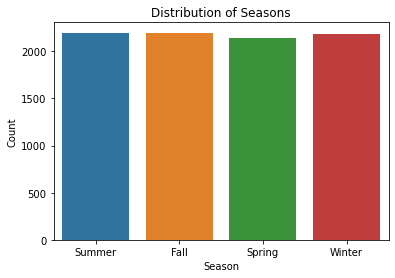

In [14]:
sns.countplot(df['season'])
plt.xlabel('Season')
plt.ylabel('Count')
plt.title('Distribution of Seasons')
plt.show()

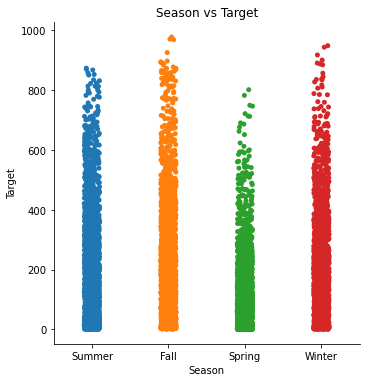

In [15]:
sns.catplot(x='season',y='target' ,data=df)
plt.xlabel('Season')
plt.ylabel('Target')
plt.title('Season vs Target')
plt.show()

##### Observation: There were more bookings during Fall and Winter

# Analysing holiday & workingday columns

In [16]:
print(df['holiday'].unique())
print(df['workingday'].unique())

[0 1]
[1 0]


### Checking for anomalies between holiday and working day
1. Holiday and workingday shouldn't be 1
2. Holiday and workingday shouldn't be 0

In [21]:
holiday_and_workingday = (df['holiday'] == 1) & (df['workingday'] == 1)
print(df[holiday_and_workingday])

Empty DataFrame
Columns: [season, holiday, workingday, weather, temp, atemp, humidity, windspeed, target, year, month, day, hour]
Index: []


In [39]:
not_holiday_and_not_workingday = (df['holiday'] == 0) & (df['workingday'] == 0)
df[not_holiday_and_not_workingday].head()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,target,year,month,day,hour
6,Winter,0,0,Clear + Few clouds,24.60,29.545,73,12.9980,395,2012,10,6,9
8,Fall,0,0,"Light Snow, Light Rain",27.06,31.060,61,7.0015,9,2012,7,14,4
9,Spring,0,0,Clear + Few clouds,12.30,15.150,56,11.0014,78,2011,2,6,18
12,Spring,0,0,Clear + Few clouds,18.86,22.725,38,26.0027,221,2011,3,13,13
16,Winter,0,0,Clear + Few clouds,26.24,30.305,65,16.9979,647,2012,10,6,11


In [30]:
holiday_count = df['holiday'].sum()
workingday_count = df['workingday'].sum()
holiday_count, workingday_count, holiday_count + workingday_count, df.shape[0]

(248, 5924, 6172, 8708)

### Observation: There are no records with both as 0 or both as 1

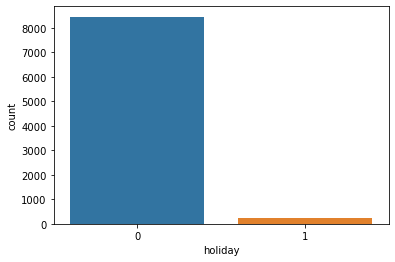

In [25]:
sns.countplot(df.holiday)
plt.show()


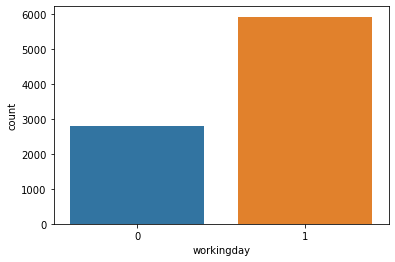

In [26]:
sns.countplot(df.workingday)
plt.show()

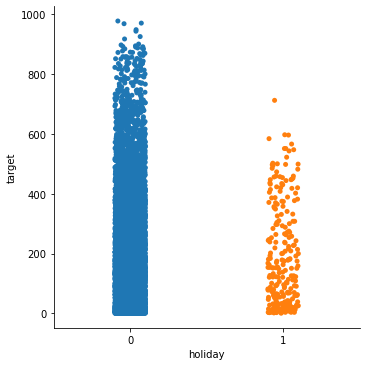

In [27]:
sns.catplot(x='holiday',y='target' ,data=df)
plt.show()

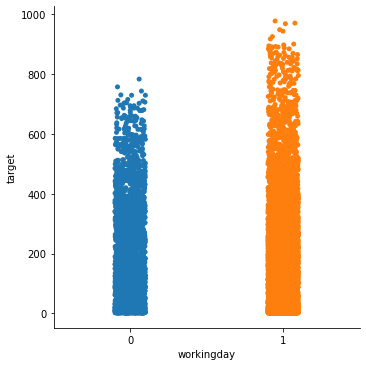

In [28]:
sns.catplot(x='workingday',y='target' ,data=df)
plt.show()

In [40]:
df.head()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,target,year,month,day,hour
0,Summer,0,1,Clear + Few clouds,22.14,25.760,77,16.9979,504,2012,5,2,19
1,Fall,0,1,Clear + Few clouds,28.70,33.335,79,19.0012,5,2012,9,5,4
2,Spring,0,1,Clear + Few clouds,5.74,6.060,50,22.0028,139,2011,1,13,9
3,Winter,0,1,Clear + Few clouds,13.94,16.665,29,8.9981,209,2011,11,18,16
4,Fall,0,1,Clear + Few clouds,30.34,33.335,51,19.0012,184,2011,9,13,13


# Splitting weather into two features

In [48]:
df[['weather1','weather2']] = df['weather'].str.split('+', 2, expand=True)

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,target,year,month,day,hour,weather1,weather2
0,Summer,0,1,Clear + Few clouds,22.14,25.760,77,16.9979,504,2012,5,2,19,Clear,Few clouds
1,Fall,0,1,Clear + Few clouds,28.70,33.335,79,19.0012,5,2012,9,5,4,Clear,Few clouds
2,Spring,0,1,Clear + Few clouds,5.74,6.060,50,22.0028,139,2011,1,13,9,Clear,Few clouds
3,Winter,0,1,Clear + Few clouds,13.94,16.665,29,8.9981,209,2011,11,18,16,Clear,Few clouds
4,Fall,0,1,Clear + Few clouds,30.34,33.335,51,19.0012,184,2011,9,13,13,Clear,Few clouds


In [49]:
#Dropping off the weather
df.drop(columns=['weather'], axis=1, inplace=True)

In [50]:
df.head()

,season,holiday,workingday,temp,atemp,humidity,windspeed,target,year,month,day,hour,weather1,weather2
0,Summer,0,1,22.14,25.760,77,16.9979,504,2012,5,2,19,Clear,Few clouds
1,Fall,0,1,28.70,33.335,79,19.0012,5,2012,9,5,4,Clear,Few clouds
2,Spring,0,1,5.74,6.060,50,22.0028,139,2011,1,13,9,Clear,Few clouds
3,Winter,0,1,13.94,16.665,29,8.9981,209,2011,11,18,16,Clear,Few clouds
4,Fall,0,1,30.34,33.335,51,19.0012,184,2011,9,13,13,Clear,Few clouds


In [51]:
#Dropping off ateam as temp is highly corelated with atemp
df.drop(columns=['atemp'], axis=1, inplace=True)
df.head()

,season,holiday,workingday,temp,humidity,windspeed,target,year,month,day,hour,weather1,weather2
0,Summer,0,1,22.14,77,16.9979,504,2012,5,2,19,Clear,Few clouds
1,Fall,0,1,28.70,79,19.0012,5,2012,9,5,4,Clear,Few clouds
2,Spring,0,1,5.74,50,22.0028,139,2011,1,13,9,Clear,Few clouds
3,Winter,0,1,13.94,29,8.9981,209,2011,11,18,16,Clear,Few clouds
4,Fall,0,1,30.34,51,19.0012,184,2011,9,13,13,Clear,Few clouds


# Checking measures of central tendencies of all the columns

In [65]:
columns = ['temp', 'humidity', 'windspeed', 'year', 'month', 'day', 'hour']

for column in columns:
    print(f"{column}: Mean:{df[column].mean()}, \
          Median:{df[column].median()}, \
          Mode:{df[column].mode()[0]}, \
          Std:{df[column].std()}")

temp: Mean:20.24302021129998,           Median:20.5,           Mode:14.76,           Std:7.8134940198665195
humidity: Mean:61.64917317409279,           Median:61.0,           Mode:88,           Std:19.199577514537708
windspeed: Mean:12.843890767110922,           Median:12.998,           Mode:0.0,           Std:8.19031407397603
year: Mean:2011.50516766192,           Median:2012.0,           Mode:2012,           Std:0.5000020047293394
month: Mean:6.528709232889297,           Median:7.0,           Mode:11,           Std:3.4408790835747807
day: Mean:10.009531465319247,           Median:10.0,           Mode:14,           Std:5.48053981182168
hour: Mean:11.581189710610932,           Median:12.0,           Mode:10,           Std:6.890533592122802


In [55]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
holiday,8708.0,0.028480,0.166348,0.00,0.0000,0.000,0.0000,1.0000
workingday,8708.0,0.680294,0.466389,0.00,0.0000,1.000,1.0000,1.0000
temp,8708.0,20.243020,7.813494,0.82,13.9400,20.500,26.2400,41.0000
humidity,8708.0,61.649173,19.199578,0.00,46.0000,61.000,77.0000,100.0000
windspeed,8708.0,12.843891,8.190314,0.00,7.0015,12.998,16.9979,56.9969
target,8708.0,193.007005,181.552211,1.00,43.0000,148.000,286.0000,977.0000
year,8708.0,2011.505168,0.500002,2011.00,2011.0000,2012.000,2012.0000,2012.0000
month,8708.0,6.528709,3.440879,1.00,4.0000,7.000,10.0000,12.0000
day,8708.0,10.009531,5.480540,1.00,5.0000,10.000,15.0000,19.0000
hour,8708.0,11.581190,6.890534,0.00,6.0000,12.000,18.0000,23.0000


### Observation: There are no possible outliers as mean and median are nearly same

# Comparing the columns with target variable

Distribution of :holiday


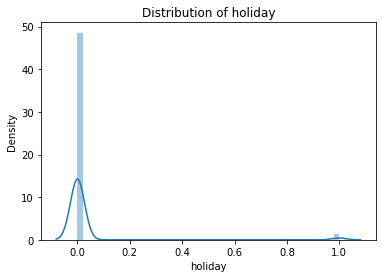

Distribution of :workingday


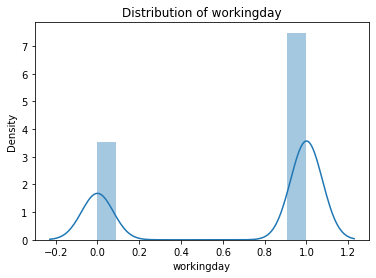

Distribution of :temp


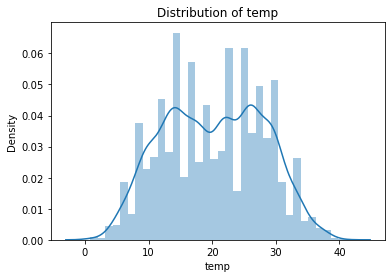

Distribution of :humidity


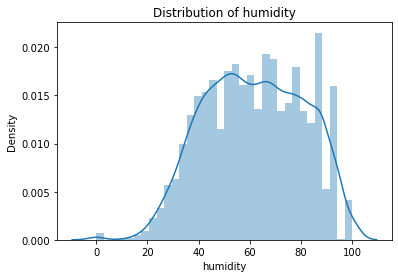

Distribution of :windspeed


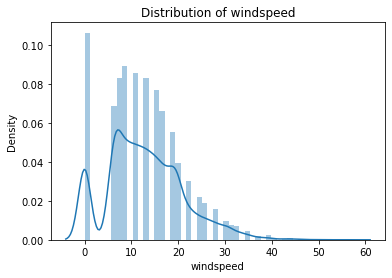

Distribution of :target


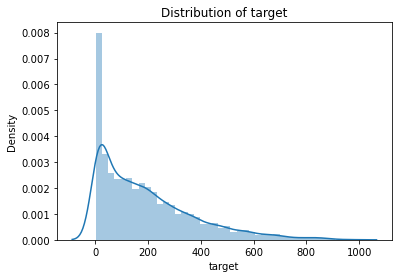

Distribution of :year


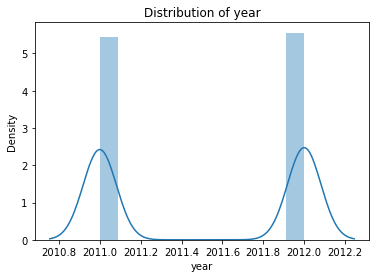

Distribution of :month


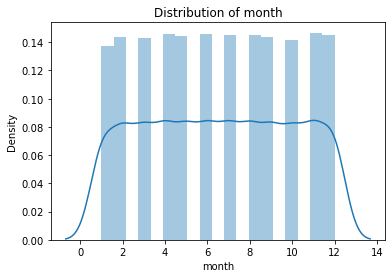

Distribution of :day


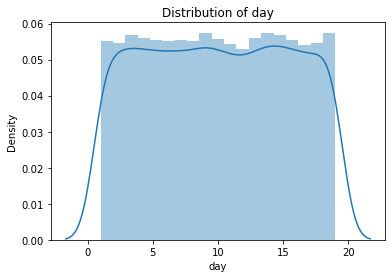

Distribution of :hour


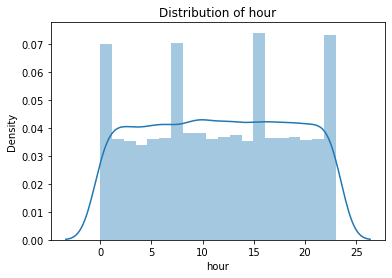

In [68]:
#Distribution of numerical columns
for column in df.select_dtypes(exclude='object'):
    print(f'Distribution of :{column}')
    sns.distplot(df[column])
    plt.xlabel(f'{column}')
    plt.title(f'Distribution of {column}')
    plt.show()

Scatter plot for :holiday


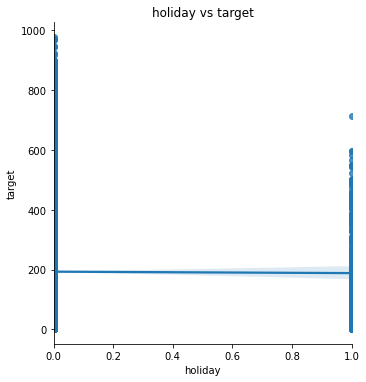

Scatter plot for :workingday


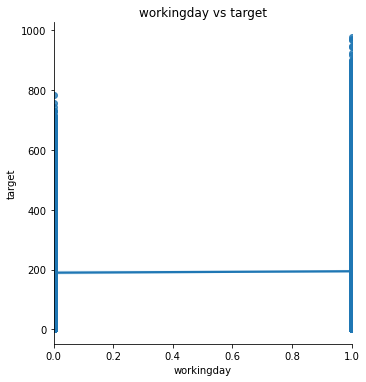

Scatter plot for :temp


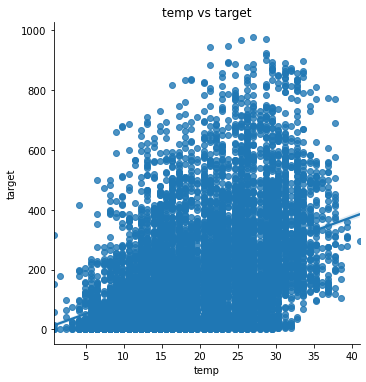

Scatter plot for :humidity


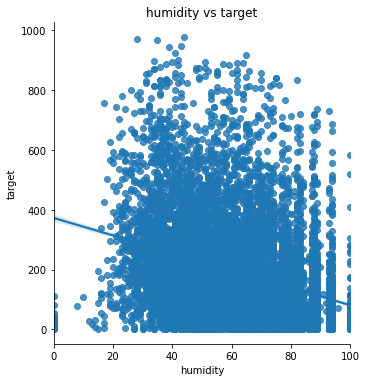

Scatter plot for :windspeed


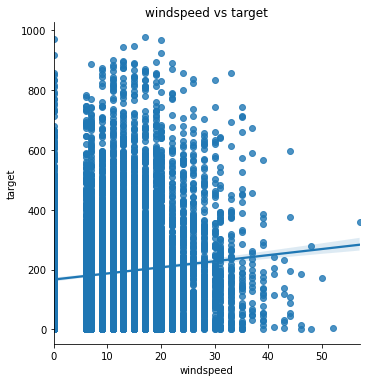

Scatter plot for :target


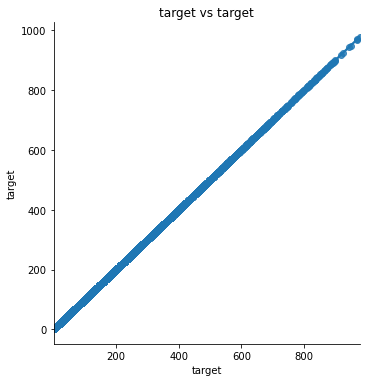

Scatter plot for :year


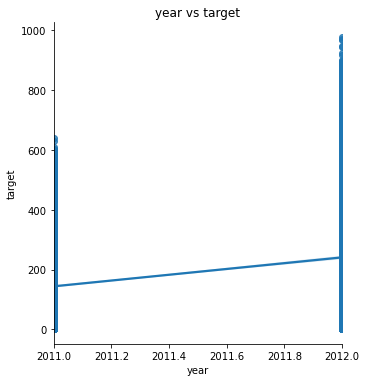

Scatter plot for :month


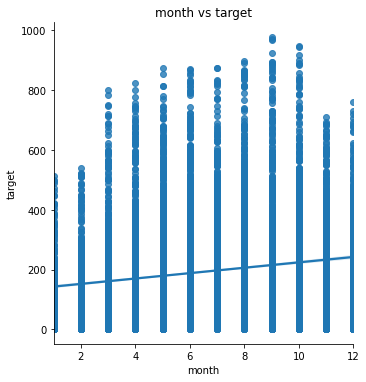

Scatter plot for :day


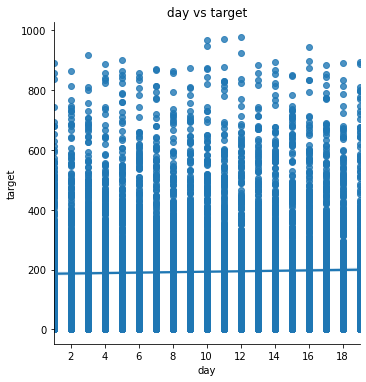

Scatter plot for :hour


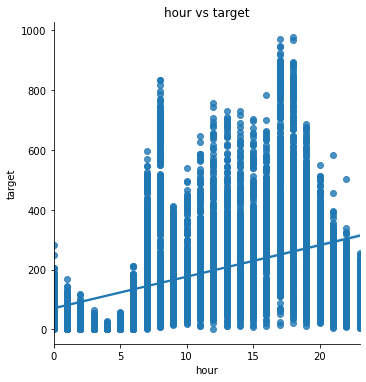

In [78]:
for column in df.select_dtypes(exclude='object'):
    print(f'Scatter plot for :{column}')
    sns.lmplot(x=column, y='target', data=df)
    plt.xlabel(f'{column}')
    plt.ylabel('target')
    plt.title(f'{column} vs target')
    plt.show()

### Observations: 
1. temperature has a positive trend with target
2. humidity has a negative trend with target
3. windsped has a positive trend with target
4. month and hour has a positive trend with target

In [79]:
df.head()

,season,holiday,workingday,temp,humidity,windspeed,target,year,month,day,hour,weather1,weather2
0,Summer,0,1,22.14,77,16.9979,504,2012,5,2,19,Clear,Few clouds
1,Fall,0,1,28.70,79,19.0012,5,2012,9,5,4,Clear,Few clouds
2,Spring,0,1,5.74,50,22.0028,139,2011,1,13,9,Clear,Few clouds
3,Winter,0,1,13.94,29,8.9981,209,2011,11,18,16,Clear,Few clouds
4,Fall,0,1,30.34,51,19.0012,184,2011,9,13,13,Clear,Few clouds


# We could start machine learning

In [83]:
pipeline = Pipeline(steps=[('label_encoder', LabelEncoder())])
pipeline.fit_transform(df)

TypeError: fit_transform() takes 2 positional arguments but 3 were given